In [27]:
!pip install streamlit pandas numpy plotly seaborn matplotlib

In [28]:
!pip uninstall -y numpy tensorflow
!pip install numpy==1.23.5

Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
Found existing installation: tensorflow 2.12.0
Uninstalling tensorflow-2.12.0:
  Successfully uninstalled tensorflow-2.12.0
  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
orbax-checkpoint 0.11.9 requires jax>=0.5.0, but you have jax 0.4.30 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
numba 0.61.0 requires numpy<2.2,>=1

In [1]:
!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1 tensorflow==2.12.0 pandas

  Using cached tensorflow-2.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
Using cached tensorflow-2.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (586.0 MB)


In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report


In [4]:
# %%
# Custom Transformer Blocks
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def get_config(self):
        config = super().get_config()
        return config

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [5]:
# %%
# Data loading and preprocessing function
def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path, encoding='latin-1')
    data.drop('Response Id', axis=1, inplace=True)
    new = ['Q'+str(i) for i in range(1, len(data.columns))]
    new.append('Personality')
    data.columns = new

    classes = ['ESTJ', 'ENTJ', 'ESFJ', 'ENFJ', 'ISTJ', 'ISFJ', 'INTJ', 'INFJ',
               'ESTP', 'ESFP', 'ENTP', 'ENFP', 'ISTP', 'ISFP', 'INTP', 'INFP']
    personality_mapping = {personality: idx for idx, personality in enumerate(classes)}

    X = data.drop('Personality', axis=1)
    y = data['Personality'].map(personality_mapping)

    return X, y, classes

In [6]:
# %%
# Training and evaluation utilities
def create_callbacks():
    return [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            mode='min'
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6,
            mode='min'
        )
    ]


In [7]:
# %%
def evaluate_model(model, history, x_test, y_test, classes, model_name):
    # Calculate predictions
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Print classification report
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred_classes, target_names=classes))

    # Plot confusion matrix
    plt.figure(figsize=(12, 8))
    cm = confusion_matrix(y_test, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model.evaluate(x_test, y_test)


In [8]:
# %%
# Load and preprocess data
X, y, classes = load_and_preprocess_data('/content/16P.csv')

# Split data
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Scale features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [9]:
# %%
# Create Transformer model function
def create_transformer_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Embedding layer to project the input features
    x = layers.Dense(256)(inputs)
    x = layers.Reshape((1, 256))(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    # Add positional encoding
    positions = np.arange(1)[:, np.newaxis]
    indices = np.arange(256)[np.newaxis, :]
    pos_encoding = np.sin(positions * (1 / np.power(10000, (2 * indices) / 256)))
    pos_encoding = pos_encoding.astype('float32')  # Ensure float32 dtype
    x = layers.Add()([x, keras.backend.constant(pos_encoding)])

    # Transformer blocks
    for _ in range(3):  # Using a loop instead of list for cleaner implementation
        transformer_block = TransformerBlock(embed_dim=256, num_heads=8, ff_dim=512, rate=0.1)
        x = transformer_block(x)

    # Global average pooling and final dense layers
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

In [10]:
# %%
# Train Transformer model
print("\nTraining Transformer Model:")
transformer_model = create_transformer_model(input_shape=(x_train.shape[1],), num_classes=16)
transformer_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

transformer_history = transformer_model.fit(
    x_train_scaled, y_train,
    epochs=2,
    batch_size=32,
    validation_data=(x_test_scaled, y_test),
    callbacks=create_callbacks(),
    verbose=1
)



Training Transformer Model:
Epoch 1/2
1500/1500 [==============================] - 392s 258ms/step - loss: 0.3324 - accuracy: 0.9189 - val_loss: 0.1558 - val_accuracy: 0.9703 - lr: 1.0000e-04
Epoch 2/2
1500/1500 [==============================] - 387s 258ms/step - loss: 0.1623 - accuracy: 0.9706 - val_loss: 0.1260 - val_accuracy: 0.9808 - lr: 1.0000e-04



Evaluating Transformer Model:
375/375 [==============================] - 9s 23ms/step

Transformer Model Classification Report:
              precision    recall  f1-score   support

        ESTJ       0.99      0.98      0.99       752
        ENTJ       0.98      0.98      0.98       747
        ESFJ       0.98      0.99      0.98       749
        ENFJ       0.97      0.98      0.98       749
        ISTJ       0.99      0.98      0.98       751
        ISFJ       0.97      0.98      0.98       748
        INTJ       0.97      0.99      0.98       749
        INFJ       0.98      0.98      0.98       752
        ESTP       0.98      0.99      0.98       750
        ESFP       0.99      0.97      0.98       754
        ENTP       0.99      0.99      0.99       752
        ENFP       0.98      0.99      0.98       752
        ISTP       0.98      0.97      0.98       751
        ISFP       0.98      0.98      0.98       749
        INTP       0.99      0.99      0.99       748
      

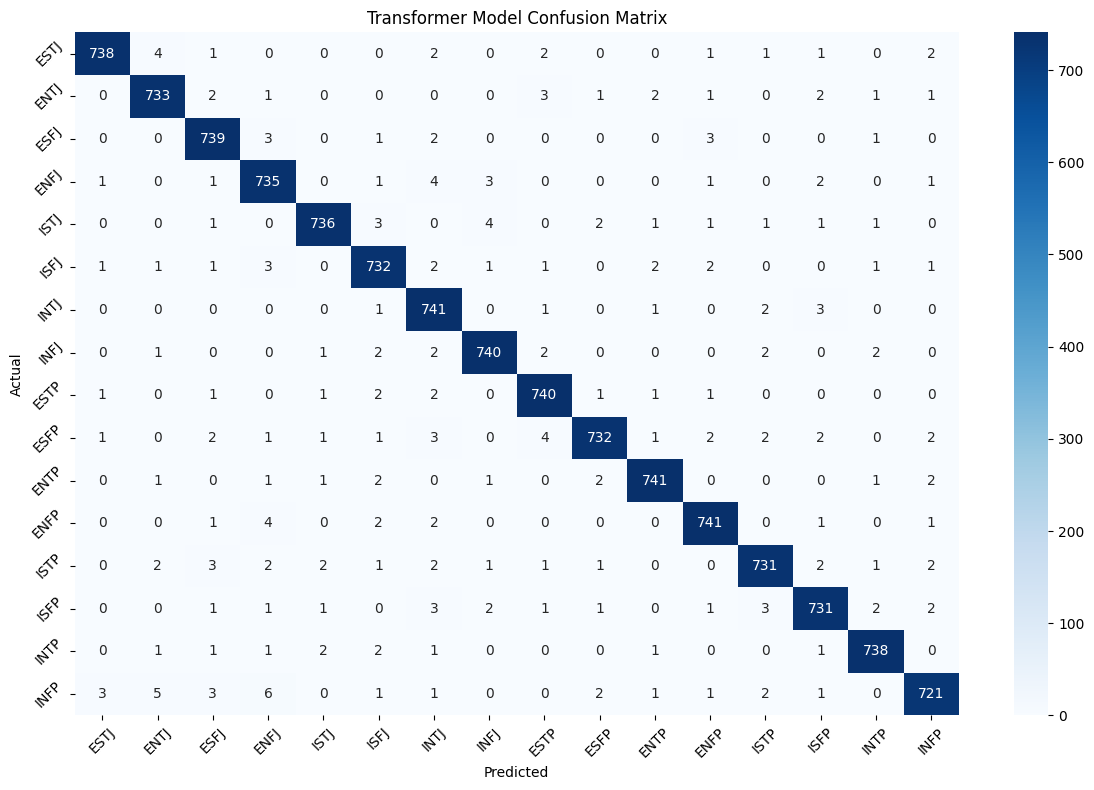

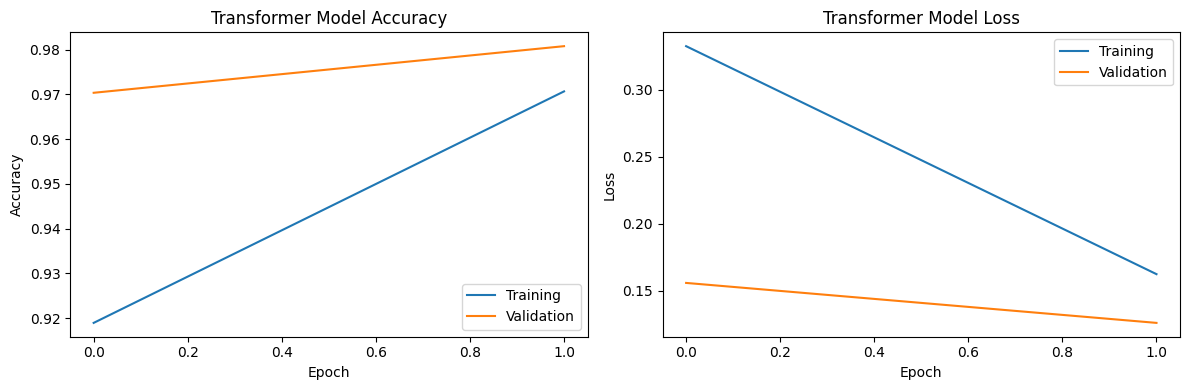

375/375 [==============================] - 8s 23ms/step - loss: 0.1260 - accuracy: 0.9808


In [11]:
# %%
# Evaluate Transformer model
print("\nEvaluating Transformer Model:")
transformer_loss, transformer_acc = evaluate_model(
    transformer_model, transformer_history, x_test_scaled, y_test,
    classes, "Transformer Model"
)


In [12]:
# %%
# LSTM model creation function
def create_lstm_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Reshape input for LSTM
    x = layers.Reshape((1, input_shape[0]))(inputs)

    # LSTM layers
    x = layers.LSTM(256, return_sequences=True)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.LSTM(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    # Dense layers
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)

In [13]:
# %%
# Train LSTM model
print("\nTraining LSTM Model:")
lstm_model = create_lstm_model(input_shape=(x_train.shape[1],), num_classes=16)
lstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

lstm_history = lstm_model.fit(
    x_train_scaled, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(x_test_scaled, y_test),
    callbacks=create_callbacks(),
    verbose=1
)


Training LSTM Model:
Epoch 1/10
1500/1500 [==============================] - 23s 12ms/step - loss: 1.2979 - accuracy: 0.6266 - val_loss: 0.2961 - val_accuracy: 0.9483 - lr: 1.0000e-04
Epoch 2/10
1500/1500 [==============================] - 16s 11ms/step - loss: 0.4726 - accuracy: 0.8814 - val_loss: 0.1701 - val_accuracy: 0.9707 - lr: 1.0000e-04
Epoch 3/10
1500/1500 [==============================] - 17s 11ms/step - loss: 0.3252 - accuracy: 0.9225 - val_loss: 0.1388 - val_accuracy: 0.9781 - lr: 1.0000e-04
Epoch 4/10
1500/1500 [==============================] - 16s 10ms/step - loss: 0.2603 - accuracy: 0.9412 - val_loss: 0.1264 - val_accuracy: 0.9820 - lr: 1.0000e-04
Epoch 5/10
1500/1500 [==============================] - 16s 11ms/step - loss: 0.2306 - accuracy: 0.9495 - val_loss: 0.1222 - val_accuracy: 0.9840 - lr: 1.0000e-04
Epoch 6/10
1500/1500 [==============================] - 16s 11ms/step - loss: 0.2034 - accuracy: 0.9568 - val_loss: 0.1204 - val_accuracy: 0.9847 - lr: 1.0000e-04



Evaluating LSTM Model:
375/375 [==============================] - 2s 3ms/step

LSTM Model Classification Report:
              precision    recall  f1-score   support

        ESTJ       0.99      0.99      0.99       752
        ENTJ       0.99      0.99      0.99       747
        ESFJ       0.98      0.99      0.99       749
        ENFJ       0.99      0.99      0.99       749
        ISTJ       0.99      0.99      0.99       751
        ISFJ       0.98      0.99      0.98       748
        INTJ       0.98      0.99      0.98       749
        INFJ       0.99      0.99      0.99       752
        ESTP       0.99      0.99      0.99       750
        ESFP       0.99      0.98      0.98       754
        ENTP       0.99      0.98      0.99       752
        ENFP       0.99      0.99      0.99       752
        ISTP       0.98      0.98      0.98       751
        ISFP       0.98      0.98      0.98       749
        INTP       0.99      0.99      0.99       748
        INFP       0.

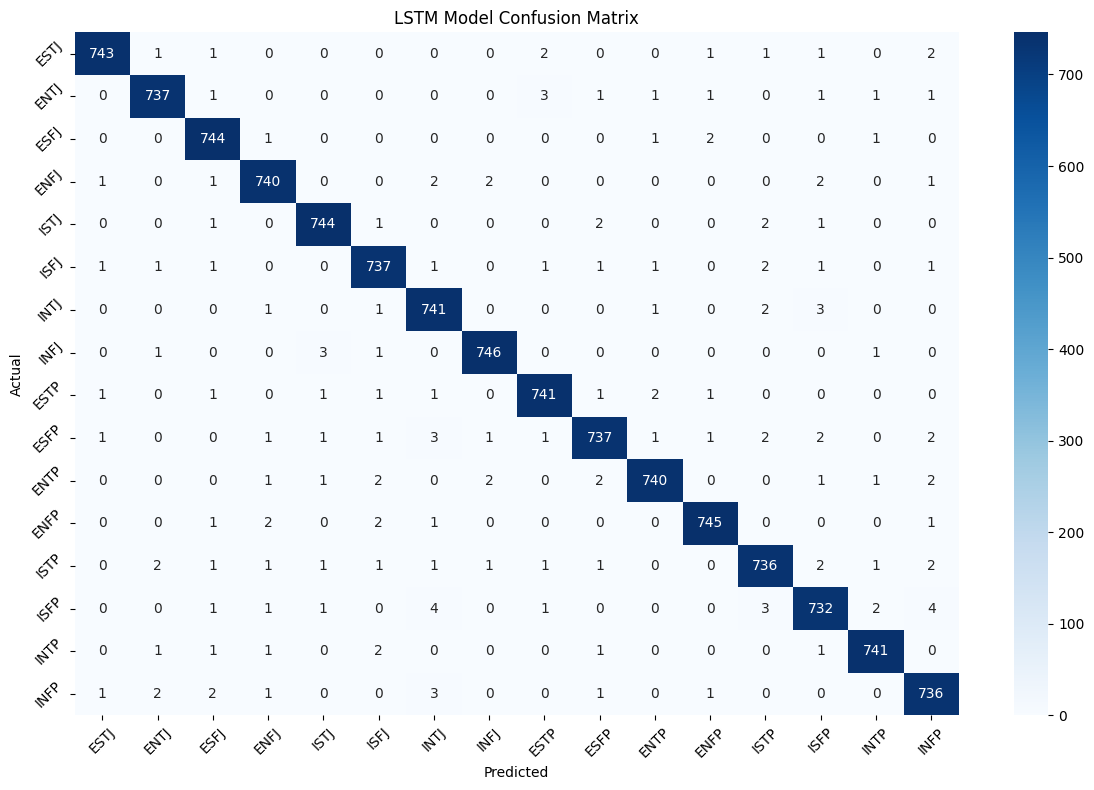

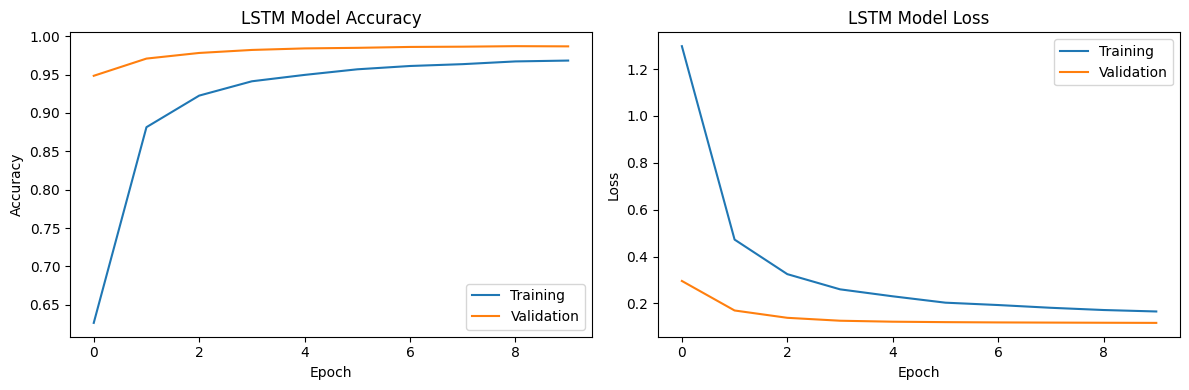

375/375 [==============================] - 1s 3ms/step - loss: 0.1172 - accuracy: 0.9867


In [14]:
# %%
# Evaluate LSTM model
print("\nEvaluating LSTM Model:")
lstm_loss, lstm_acc = evaluate_model(
    lstm_model, lstm_history, x_test_scaled, y_test,
    classes, "LSTM Model"
)

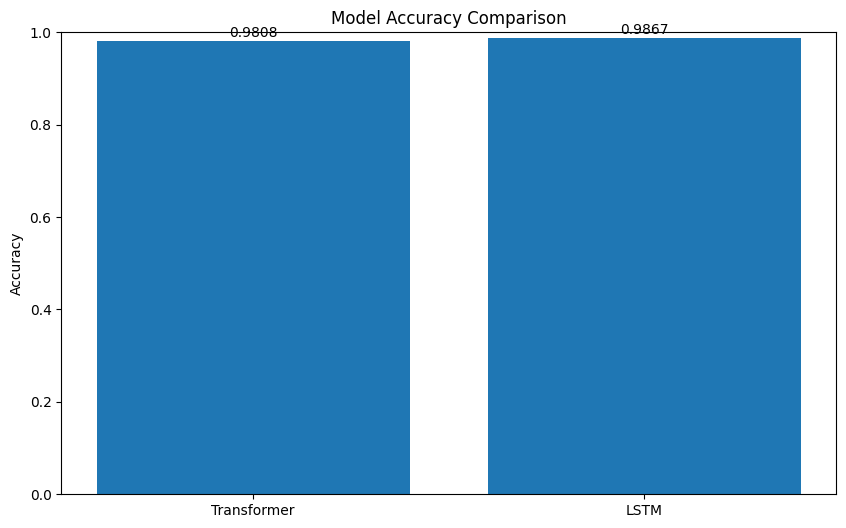

In [15]:
# %%
# Compare models
plt.figure(figsize=(10, 6))
models = ['Transformer', 'LSTM']
accuracies = [transformer_acc, lstm_acc]
plt.bar(models, accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
plt.show()

In [16]:
# %%
# Save the better performing model
if lstm_acc > transformer_acc:
    lstm_model.save('Best_Personality_Model.h5')
    print("\nLSTM model performed better and has been saved.")
else:
    transformer_model.save('Best_Personality_Model.h5')
    print("\nTransformer model performed better and has been saved.")


LSTM model performed better and has been saved.


In [17]:
!npm install localtunnel

⠙⠹⠸⠼⠴⠦
up to date, audited 23 packages in 766ms
⠦
⠦3 packages are looking for funding
⠦  run `npm fund` for details
⠦
2 high severity vulnerabilities

To address all issues (including breaking changes), run:
  npm audit fix --force

Run `npm audit` for details.
⠦

In [18]:
!pip install streamlit

In [18]:
%%writefile DeepPersona.py
import streamlit as st
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from datetime import datetime

# Set page config
st.set_page_config(page_title="MBTI Personality Test", layout="wide")

# Custom CSS with enhanced styling
st.markdown("""
    <style>
    .main {
        padding: 2rem;
    }
    .stButton>button {
        width: 100%;
        background-color: #000000;
        color: white;
        padding: 0.5rem;
        border-radius: 0.3rem;
        border: none;
        cursor: pointer;
    }
    .stButton>button:hover {
        background-color: #45a049;
    }
    .personality-card {
        padding: 1.5rem;
        border-radius: 0.5rem;
        background-color: #000000;
        margin: 1rem 0;
        box-shadow: 0 2px 4px rgba(0,0,0,0.1);
    }
    </style>
""", unsafe_allow_html=True)

# Load the model
@st.cache_resource
def load_model():
    return tf.keras.models.load_model('/content/Best_Personality_Model.h5')

# Actual MBTI questions with their categories
questions = [
    {"text": "You regularly make new friends.", "category": "Extraversion"},
    {"text": "You spend a lot of your free time exploring various random topics that pique your interest.", "category": "Intuition"},
    {"text": "Seeing other people cry can easily make you feel like you want to cry too.", "category": "Feeling"},
    {"text": "You often make a backup plan for a backup plan.", "category": "Judging"},
    {"text": "You usually stay calm, even under a lot of pressure.", "category": "Thinking"},
    {"text": "At social events, you rarely try to introduce yourself to new people and mostly talk to the ones you already know.", "category": "Introversion"},
    {"text": "You prefer to completely finish one project before starting another.", "category": "Judging"},
    {"text": "You are very sentimental.", "category": "Feeling"},
    {"text": "You like to use organizing tools like schedules and lists.", "category": "Judging"},
    {"text": "Even a small mistake can cause you to doubt your overall abilities and knowledge.", "category": "Feeling"},
    {"text": "You feel comfortable just walking up to someone you find interesting and striking up a conversation.", "category": "Extraversion"},
    {"text": "You are not too interested in discussing various interpretations and analyses of creative works.", "category": "Sensing"},
    {"text": "You are more inclined to follow your head than your heart.", "category": "Thinking"},
    {"text": "You usually prefer just doing what you feel like at any given moment instead of planning a particular daily routine.", "category": "Perceiving"},
    {"text": "You rarely worry about whether you make a good impression on people you meet.", "category": "Thinking"},
    {"text": "You enjoy participating in group activities.", "category": "Extraversion"},
    {"text": "You like books and movies that make you come up with your own interpretation of the ending.", "category": "Intuition"},
    {"text": "Your happiness comes more from helping others accomplish things than your own accomplishments.", "category": "Feeling"},
    {"text": "You are interested in so many things that you find it difficult to choose what to try next.", "category": "Perceiving"},
    {"text": "You are prone to worrying that things will take a turn for the worse.", "category": "Feeling"},
    {"text": "You avoid leadership roles in group settings.", "category": "Introversion"},
    {"text": "You are definitely not an artistic type of person.", "category": "Sensing"},
    {"text": "You think the world would be a better place if people relied more on rationality and less on their feelings.", "category": "Thinking"},
    {"text": "You prefer to do your chores before allowing yourself to relax.", "category": "Judging"},
    {"text": "You enjoy watching people argue.", "category": "Thinking"},
    {"text": "You tend to avoid drawing attention to yourself.", "category": "Introversion"},
    {"text": "Your mood can change very quickly.", "category": "Feeling"},
    {"text": "You lose patience with people who are not as efficient as you.", "category": "Judging"},
    {"text": "You often end up doing things at the last possible moment.", "category": "Perceiving"},
    {"text": "You have always been fascinated by the question of what, if anything, happens after death.", "category": "Intuition"},
    {"text": "You usually prefer to be around others rather than on your own.", "category": "Extraversion"},
    {"text": "You become bored or lose interest when the discussion gets highly theoretical.", "category": "Sensing"},
    {"text": "You find it easy to empathize with a person whose experiences are very different from yours.", "category": "Feeling"},
    {"text": "You usually postpone finalizing decisions for as long as possible.", "category": "Perceiving"},
    {"text": "You rarely second-guess the choices that you have made.", "category": "Thinking"},
    {"text": "After a long and exhausting week, a lively social event is just what you need.", "category": "Extraversion"},
    {"text": "You enjoy going to art museums.", "category": "Intuition"},
    {"text": "You often have a hard time understanding other people's feelings.", "category": "Thinking"},
    {"text": "You like to have a to-do list for each day.", "category": "Judging"},
    {"text": "You rarely feel insecure.", "category": "Thinking"},
    {"text": "You avoid making phone calls.", "category": "Introversion"},
    {"text": "You often spend a lot of time trying to understand views that are very different from your own.", "category": "Intuition"},
    {"text": "In your social circle, you are often the one who contacts your friends and initiates activities.", "category": "Extraversion"},
    {"text": "If your plans are interrupted, your top priority is to get back on track as soon as possible.", "category": "Judging"},
    {"text": "You are still bothered by mistakes that you made a long time ago.", "category": "Feeling"},
    {"text": "You rarely contemplate the reasons for human existence or the meaning of life.", "category": "Sensing"},
    {"text": "Your emotions control you more than you control them.", "category": "Feeling"},
    {"text": "You take great care not to make people look bad, even when it is completely their fault.", "category": "Feeling"},
    {"text": "Your personal work style is closer to spontaneous bursts of energy than organized and consistent efforts.", "category": "Perceiving"},
    {"text": "When someone thinks highly of you, you wonder how long it will take them to feel disappointed in you.", "category": "Feeling"},
    {"text": "You would love a job that requires you to work alone most of the time.", "category": "Introversion"},
    {"text": "You believe that pondering abstract philosophical questions is a waste of time.", "category": "Sensing"},
    {"text": "You feel more drawn to places with busy, bustling atmospheres than quiet, intimate places.", "category": "Extraversion"},
    {"text": "You know at first glance how someone is feeling.", "category": "Feeling"},
    {"text": "You often feel overwhelmed.", "category": "Feeling"},
    {"text": "You complete things methodically without skipping over any steps.", "category": "Judging"},
    {"text": "You are very intrigued by things labeled as controversial.", "category": "Intuition"},
    {"text": "You would pass along a good opportunity if you thought someone else needed it more.", "category": "Feeling"},
    {"text": "You struggle with deadlines.", "category": "Perceiving"},
    {"text": "You feel confident that things will work out for you.", "category": "Thinking"}
]


# Complete personality types dictionary
personality_types = {
    'ISTJ': {
        'name': 'Logistician',
        'traits': ['Introverted', 'Sensing', 'Thinking', 'Judging'],
        'description': "Practical and fact-minded individuals who emphasize reliability, structure, and honor above all else. They are detail-oriented organizers who thrive on order and systematic approaches.",
        'strengths': ['Honest', 'Direct', 'Strong-willed', 'Very responsible', 'Calm and practical', 'Create and enforce order'],
        'weaknesses': ['Stubborn', 'Insensitive', 'Always by the book', 'Judgmental', 'Often unreasonably blame themselves']
    },
    'ISFJ': {
        'name': 'Defender',
        'traits': ['Introverted', 'Sensing', 'Feeling', 'Judging'],
        'description': "Dedicated and protective individuals who are always ready to defend their loved ones. They are excellent caregivers who live to serve others and bring harmony to their environment.",
        'strengths': ['Supportive', 'Reliable', 'Patient', 'Observant', 'Detail-oriented', 'Enthusiastic'],
        'weaknesses': ['Overload themselves', 'Shy and reserved', 'Take things personally', 'Repress their feelings']
    },
    'INFJ': {
        'name': 'Advocate',
        'traits': ['Introverted', 'Intuitive', 'Feeling', 'Judging'],
        'description': "Quiet yet idealistic individuals who never stop looking for ways to make the world a better place. They combine creativity with a strong sense of purpose.",
        'strengths': ['Creative', 'Insightful', 'Principled', 'Passionate', 'Altruistic'],
        'weaknesses': ['Sensitive to criticism', 'Private', 'Perfectionist', 'Can burn out easily']
    },
    'INTJ': {
        'name': 'Architect',
        'traits': ['Introverted', 'Intuitive', 'Thinking', 'Judging'],
        'description': "Imaginative and strategic thinkers with a plan for everything. They combine innovation with purpose and drive to achieve their goals.",
        'strengths': ['Rational', 'Informed', 'Independent', 'Determined', 'Curious', 'Versatile'],
        'weaknesses': ['Arrogant', 'Dismissive of emotions', 'Overly critical', 'Combative']
    },
    'ISTP': {
        'name': 'Virtuoso',
        'traits': ['Introverted', 'Sensing', 'Thinking', 'Perceiving'],
        'description': "Bold and practical experimenters, masters of tools and techniques. They enjoy exploration and building things, often seeking thrills and hands-on experiences.",
        'strengths': ['Optimistic', 'Creative', 'Spontaneous', 'Rational', 'Practical'],
        'weaknesses': ['Stubborn', 'Insensitive', 'Private', 'Easily bored']
    },
    'ISFP': {
        'name': 'Adventurer',
        'traits': ['Introverted', 'Sensing', 'Feeling', 'Perceiving'],
        'description': "Flexible and charming artists, always ready to explore and experience something new. They live in the moment and seek out beauty and adventure.",
        'strengths': ['Charming', 'Sensitive to others', 'Imaginative', 'Passionate', 'Curious'],
        'weaknesses': ['Fiercely independent', 'Unpredictable', 'Easily stressed', 'Overly competitive']
    },
    'INFP': {
        'name': 'Mediator',
        'traits': ['Introverted', 'Intuitive', 'Feeling', 'Perceiving'],
        'description': "Poetic, kind, and altruistic individuals who are always eager to help a good cause. They seek to understand themselves and others on a deeper level.",
        'strengths': ['Empathetic', 'Creative', 'Open-minded', 'Passionate', 'Dedicated'],
        'weaknesses': ['Too idealistic', 'Self-isolating', 'Impractical', 'Takes things personally']
    },
    'INTP': {
        'name': 'Logician',
        'traits': ['Introverted', 'Intuitive', 'Thinking', 'Perceiving'],
        'description': "Innovative inventors with an unquenchable thirst for knowledge. They love patterns and are driven by the desire to find unifying principles.",
        'strengths': ['Analytical', 'Original', 'Open-minded', 'Curious', 'Objective'],
        'weaknesses': ['Very private', 'Insensitive', 'Absent-minded', 'Condescending']
    },
    'ESTP': {
        'name': 'Entrepreneur',
        'traits': ['Extroverted', 'Sensing', 'Thinking', 'Perceiving'],
        'description': "Smart, energetic, and very perceptive people who truly enjoy living on the edge. They are action-oriented problem solvers who excel in crisis situations.",
        'strengths': ['Bold', 'Rational', 'Practical', 'Original', 'Perceptive'],
        'weaknesses': ['Impatient', 'Risk-prone', 'Unstructured', 'May miss the bigger picture']
    },
    'ESFP': {
        'name': 'Entertainer',
        'traits': ['Extroverted', 'Sensing', 'Feeling', 'Perceiving'],
        'description': "Spontaneous, energetic, and enthusiastic people who live life to the fullest. They love being the center of attention and bringing joy to others.",
        'strengths': ['Bold', 'Original', 'Practical', 'Observant', 'Excellent people skills'],
        'weaknesses': ['Sensitive', 'Conflict-averse', 'Easily bored', 'Poor long-term planners']
    },
    'ENFP': {
        'name': 'Campaigner',
        'traits': ['Extroverted', 'Intuitive', 'Feeling', 'Perceiving'],
        'description': "Enthusiastic, creative, and sociable free spirits who can always find a reason to smile. They are excellent communicators who love helping others explore their creative potential.",
        'strengths': ['Curious', 'Observant', 'Energetic', 'Excellent communicators', 'Fun and spontaneous'],
        'weaknesses': ['Poor practical skills', 'Find it difficult to focus', 'Overthink things', 'Get stressed easily']
    },
    'ENTP': {
        'name': 'Debater',
        'traits': ['Extroverted', 'Intuitive', 'Thinking', 'Perceiving'],
        'description': "Smart and curious thinkers who cannot resist an intellectual challenge. They are natural debaters who love playing with ideas and thinking outside the box.",
        'strengths': ['Knowledgeable', 'Quick thinkers', 'Original', 'Excellent brainstormers', 'Charismatic'],
        'weaknesses': ['Very argumentative', 'Insensitive', 'Intolerant', 'Can find it difficult to focus']
    },
    'ESTJ': {
        'name': 'Executive',
        'traits': ['Extroverted', 'Sensing', 'Thinking', 'Judging'],
        'description': "Excellent administrators, unsurpassed at managing things and people. They are natural leaders who value tradition, order, and security.",
        'strengths': ['Dedicated', 'Strong-willed', 'Direct and honest', 'Loyal and patient', 'Excellent organizers'],
        'weaknesses': ['Inflexible', 'Stubborn', 'Judgmental', 'Too focused on social status']
    },
    'ESFJ': {
        'name': 'Consul',
        'traits': ['Extroverted', 'Sensing', 'Feeling', 'Judging'],
        'description': "Extraordinarily caring, social, and popular people who are always eager to help. They are focused on harmony and cooperation in their environment.",
        'strengths': ['Strong practical skills', 'Strong sense of duty', 'Very loyal', 'Sensitive and warm', 'Good at connecting'],
        'weaknesses': ['Worried about social status', 'Inflexible', 'Reluctant to innovate', 'Vulnerable to criticism']
    },
    'ENFJ': {
        'name': 'Protagonist',
        'traits': ['Extroverted', 'Intuitive', 'Feeling', 'Judging'],
        'description': "Charismatic and inspiring leaders who are able to mesmerize their listeners. They are natural leaders focused on helping others achieve their potential.",
        'strengths': ['Tolerant', 'Reliable', 'Charismatic', 'Altruistic', 'Natural leaders'],
        'weaknesses': ['Overly idealistic', 'Too selfless', 'Too sensitive', 'Fluctuating self-esteem']
    },
    'ENTJ': {
        'name': 'Commander',
        'traits': ['Extroverted', 'Intuitive', 'Thinking', 'Judging'],
        'description': "Bold, imaginative, and strong-willed leaders who always find a way - or make one. They are strategic thinkers who can turn their ideas into concrete plans.",
        'strengths': ['Efficient', 'Energetic', 'Self-confident', 'Strong-willed', 'Strategic thinkers', 'Natural leaders'],
        'weaknesses': ['Stubborn and dominant', 'Intolerant', 'Impatient', 'Arrogant', 'Poor handling of emotions']
    }
}

def calculate_trait_scores(answers, questions):
    """Calculate scores for each MBTI dimension based on question responses"""
    # Create a feature vector of all answers (60 features)
    feature_vector = np.zeros(60)  # Initialize with zeros

    # Fill in the available answers
    for i, answer in enumerate(answers):
        if i < 60:  # Ensure we don't exceed the vector size
            feature_vector[i] = answer

    # Also calculate the trait scores as before
    scores = {
        'Extraversion': [],
        'Intuition': [],
        'Thinking': [],
        'Judging': []
    }

    for answer, question in zip(answers, questions):
        category = question['category']
        if category in ['Extraversion', 'Intuition', 'Thinking', 'Judging']:
            scores[category].append(answer)
        elif category in ['Introversion', 'Sensing', 'Feeling', 'Perceiving']:
            opposite_map = {
                'Introversion': 'Extraversion',
                'Sensing': 'Intuition',
                'Feeling': 'Thinking',
                'Perceiving': 'Judging'
            }
            scores[opposite_map[category]].append(-answer)

    final_scores = {}
    for trait, values in scores.items():
        if values:
            avg = np.mean(values)
            final_scores[trait] = (avg + 3) / 6
        else:
            final_scores[trait] = 0.5

    return list(final_scores.values()), feature_vector

def create_radar_chart(scores):
    """Create a radar chart for personality traits"""
    categories = ['Extraversion', 'Intuition', 'Thinking', 'Judging']

    fig = go.Figure()

    fig.add_trace(go.Scatterpolar(
        r=scores,
        theta=categories,
        fill='toself',
        line_color='#4CAF50'
    ))

    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 1]
            )),
        showlegend=False
    )

    return fig

def create_personality_wheel(trait_scores):
    """Create an interactive personality wheel visualization"""
    fig = go.Figure()

    # Create the outer circle
    theta = np.linspace(0, 2*np.pi, 100)
    radius = 1
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)

    fig.add_trace(go.Scatter(
        x=x, y=y,
        mode='lines',
        line=dict(color='#4CAF50', width=2),
        showlegend=False
    ))

    # Add trait points
    angles = [0, np.pi/2, np.pi, 3*np.pi/2]
    labels = ['E-I', 'N-S', 'T-F', 'J-P']

    for angle, score, label in zip(angles, trait_scores, labels):
        r = score
        x = r * np.cos(angle)
        y = r * np.sin(angle)

        fig.add_trace(go.Scatter(
            x=[x], y=[y],
            mode='markers+text',
            marker=dict(size=12, color='#4CAF50'),
            text=label,
            textposition="top center",
            showlegend=False
        ))

    fig.update_layout(
        title="Personality Wheel",
        xaxis=dict(range=[-1.2, 1.2], zeroline=False, showgrid=False, showticklabels=False),
        yaxis=dict(range=[-1.2, 1.2], zeroline=False, showgrid=False, showticklabels=False),
        width=400,
        height=400,
        plot_bgcolor='white'
    )

    return fig

def create_cognitive_functions_chart(personality_type):
    """Create a visualization of cognitive functions stack"""
    cognitive_functions = {
        'ISTJ': ['Si', 'Te', 'Fi', 'Ne'],
        'ISFJ': ['Si', 'Fe', 'Ti', 'Ne'],
        'INFJ': ['Ni', 'Fe', 'Ti', 'Se'],
        'INTJ': ['Ni', 'Te', 'Fi', 'Se'],
        'ISTP': ['Ti', 'Se', 'Ni', 'Fe'],
        'ISFP': ['Fi', 'Se', 'Ni', 'Te'],
        'INFP': ['Fi', 'Ne', 'Si', 'Te'],
        'INTP': ['Ti', 'Ne', 'Si', 'Fe'],
        'ESTP': ['Se', 'Ti', 'Fe', 'Ni'],
        'ESFP': ['Se', 'Fi', 'Te', 'Ni'],
        'ENFP': ['Ne', 'Fi', 'Te', 'Si'],
        'ENTP': ['Ne', 'Ti', 'Fe', 'Si'],
        'ESTJ': ['Te', 'Si', 'Ne', 'Fi'],
        'ESFJ': ['Fe', 'Si', 'Ne', 'Ti'],
        'ENFJ': ['Fe', 'Ni', 'Se', 'Ti'],
        'ENTJ': ['Te', 'Ni', 'Se', 'Fi']
    }

    functions = cognitive_functions[personality_type]
    strengths = [100, 80, 60, 40]

    fig = go.Figure()

    fig.add_trace(go.Bar(
        x=functions,
        y=strengths,
        marker_color=['#4CAF50', '#81C784', '#A5D6A7', '#C8E6C9'],
        text=strengths,
        textposition='auto',
    ))

    fig.update_layout(
        title="Cognitive Functions Stack",
        xaxis_title="Cognitive Functions",
        yaxis_title="Relative Strength",
        showlegend=False
    )

    return fig

def create_trait_comparison_chart(trait_scores):
    """Create a parallel coordinates plot for trait comparisons"""
    fig = go.Figure(data=
        go.Parcoords(
            line=dict(color='#4CAF50'),
            dimensions=[
                dict(range=[0, 1], label='Extraversion-Introversion', values=[trait_scores[0]]),
                dict(range=[0, 1], label='Intuition-Sensing', values=[trait_scores[1]]),
                dict(range=[0, 1], label='Thinking-Feeling', values=[trait_scores[2]]),
                dict(range=[0, 1], label='Judging-Perceiving', values=[trait_scores[3]])
            ]
        )
    )

    fig.update_layout(
        title="Trait Spectrum Analysis",
        plot_bgcolor='white',
        paper_bgcolor='white'
    )

    return fig

def create_personality_distribution_chart(all_answers, personality_types):
    """Create a treemap visualization of personality distribution"""
    type_counts = {ptype: np.random.randint(50, 200) for ptype in personality_types.keys()}

    data = []
    for ptype, count in type_counts.items():
        info = personality_types[ptype]
        data.append({
            'Type': ptype,
            'Name': info['name'],
            'Count': count,
            'Group': f"{info['traits'][0][0]}{info['traits'][1][0]}"
        })

    df = pd.DataFrame(data)

    fig = px.treemap(
        df,
        path=['Group', 'Type', 'Name'],
        values='Count',
        color='Group',
        color_discrete_sequence=px.colors.qualitative.Set3
    )

    fig.update_layout(
        title="Personality Type Distribution",
        width=800,
        height=500
    )

    return fig

def create_trend_chart(answers):
    """Create a line chart showing answer trends"""
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=list(range(1, len(answers) + 1)),
        y=answers,
        mode='lines+markers',
        name='Response Pattern'
    ))

    fig.update_layout(
        title="Your Response Pattern",
        xaxis_title="Question Number",
        yaxis_title="Response Value",
        showlegend=False
    )

    return fig

def main():
    st.title("🧠 MBTI Personality Test")
    st.write("Discover your personality type through this comprehensive assessment!")

    # Initialize session state
    if 'answers' not in st.session_state:
        st.session_state.answers = []
        st.session_state.current_question = 0
        st.session_state.test_completed = False
        st.session_state.test_start_time = datetime.now()

    # Add bounds checking for current_question
    if st.session_state.current_question >= len(questions):
        st.session_state.current_question = len(questions) - 1
    elif st.session_state.current_question < 0:
        st.session_state.current_question = 0

    # Progress bar
    if not st.session_state.test_completed:
        progress = st.session_state.current_question / len(questions)
        st.progress(progress)
        st.write(f"Question {st.session_state.current_question + 1} of {len(questions)}")

        # Check if current_question is within bounds
        if 0 <= st.session_state.current_question < len(questions):
            # Display current question
            st.subheader(questions[st.session_state.current_question]['text'])

            # Answer options
            options = {
                "Strongly Agree": 3,
                "Agree": 2,
                "Slightly Agree": 1,
                "Neutral": 0,
                "Slightly Disagree": -1,
                "Disagree": -2,
                "Strongly Disagree": -3
            }

            cols = st.columns(len(options))

            for col, (option, value) in zip(cols, options.items()):
                if col.button(option, key=f"q{st.session_state.current_question}_{option}"):
                    st.session_state.answers.append(value)
                    if st.session_state.current_question < len(questions) - 1:
                        st.session_state.current_question += 1
                        st.rerun()
                    else:
                        st.session_state.test_completed = True
                        st.rerun()

            # Display a back button if not on the first question
            if st.session_state.current_question > 0:
                if st.button("← Previous Question"):
                    st.session_state.current_question -= 1
                    if st.session_state.answers:
                        st.session_state.answers.pop()
                    st.rerun()

    # Process results when all questions are answered
    if len(st.session_state.answers) == len(questions):
        st.session_state.test_completed = True
        test_duration = datetime.now() - st.session_state.test_start_time

        # Calculate trait scores and get feature vector
        trait_scores, feature_vector = calculate_trait_scores(st.session_state.answers, questions)

        try:
            # Load and use the model for prediction
            model = load_model()
            # Use the feature vector for prediction instead of trait scores
            prediction = model.predict(np.array([feature_vector]))

            # Determine personality type based on trait scores
            personality_type = ['E' if trait_scores[0] > 0.5 else 'I',
                              'N' if trait_scores[1] > 0.5 else 'S',
                              'T' if trait_scores[2] > 0.5 else 'F',
                              'J' if trait_scores[3] > 0.5 else 'P']
            personality_type = ''.join(personality_type)

        except Exception as e:
            st.error(f"An error occurred during model prediction. Using simplified scoring method.")
            # Fallback to simple scoring without model
            personality_type = ['E' if trait_scores[0] > 0.5 else 'I',
                              'N' if trait_scores[1] > 0.5 else 'S',
                              'T' if trait_scores[2] > 0.5 else 'F',
                              'J' if trait_scores[3] > 0.5 else 'P']
            personality_type = ''.join(personality_type)

        # Display results
        st.header("🎯 Your Personality Type Results")

        # Create columns for layout
        col1, col2 = st.columns(2)

        with col1:
            st.markdown(f"""
            <div class="personality-card">
                <h2>{personality_type} - {personality_types[personality_type]['name']}</h2>
                <p>{personality_types[personality_type]['description']}</p>
            </div>
            """, unsafe_allow_html=True)

            # Display strengths and weaknesses
            st.subheader("💪 Strengths")
            for strength in personality_types[personality_type]['strengths']:
                st.write(f"✓ {strength}")

            st.subheader("🔍 Areas for Growth")
            for weakness in personality_types[personality_type]['weaknesses']:
                st.write(f"• {weakness}")

        with col2:
            # Display radar chart
            st.plotly_chart(create_radar_chart(trait_scores))

            # Display personality wheel
            st.plotly_chart(create_personality_wheel(trait_scores))

        # Display additional visualizations
        st.header("📊 Detailed Analysis")

        # Create three columns for charts
        col1, col2, col3 = st.columns([1, 1, 1])

        with col1:
            st.plotly_chart(create_cognitive_functions_chart(personality_type))

        with col2:
            st.plotly_chart(create_trait_comparison_chart(trait_scores))

        with col3:
            st.plotly_chart(create_trend_chart(st.session_state.answers))

        # Display personality distribution
        st.plotly_chart(create_personality_distribution_chart(st.session_state.answers, personality_types))

        # Test statistics
        st.header("📝 Test Statistics")
        st.write(f"Time taken: {test_duration.total_seconds() / 60:.1f} minutes")
        st.write(f"Total questions answered: {len(st.session_state.answers)}")

# Option to retake the test
        if st.button("Retake Test"):
            st.session_state.answers = []
            st.session_state.current_question = 0
            st.session_state.test_completed = False
            st.session_state.test_start_time = datetime.now()
            st.rerun()


        # Option to download results
        results_df = pd.DataFrame({
            'Question': [q['text'] for q in questions],
            'Category': [q['category'] for q in questions],
            'Answer': st.session_state.answers
        })

        csv = results_df.to_csv(index=False)
        st.download_button(
            label="Download Your Results",
            data=csv,
            file_name=f"mbti_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv",
            mime="text/csv"
        )

if __name__ == "__main__":
    main()

Overwriting DeepPersona.py


In [19]:
!curl ipv4.icanhazip.com

34.16.69.161


In [ ]:
!streamlit run DeepPersona.py &>./logs.txt & npx localtunnel --port 8501 -y

⠙your url is: https://smart-hornets-poke.loca.lt
